In [1]:
import cartopy.crs as ccrs # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from scipy.stats import pearsonr # type: ignore
import pandas as pd # type: ignore
import xarray as xa # type: ignore

from s1cs2lib import s1_nc_geolocation

proj_nps = ccrs.NorthPolarStereo()
proj_pc = ccrs.PlateCarree()

In [2]:
s1dir = '/Data/sat/downloads/sentinel1/apasip/202001/'
amsr2dir = '/Data/sat/downloads/AMSR2/apasip/202001'
cs2file = '/Data/sat/downloads/CS2/LARM2/uit_cryosat2_L2_alongtrack_2020_01.nc'

In [3]:
# load dataframe with CS2 LARM product created in readcs2_larm.ipynb
with xa.open_dataset(cs2file) as ds:
    cs2df = ds.to_dataframe()
print(cs2df.columns)

Index(['SAR=0_SARIN=1', 'Orbit_no', 'Segment_no', 'Datenumber', 'Latitude',
       'Longitude', 'Radar_Freeboard', 'Surface_Height_WGS84',
       'Sea_Surface_Height_Interp_WGS84', 'SSH_Uncertainty',
       'Mean_Sea_Surface', 'SLA', 'Sea_Ice_Class', 'Lead_Class',
       'Sea_Ice_Roughness', 'Sea_Ice_Concentration', 'orbit_no'],
      dtype='object')


In [4]:
# load dataframe with intersections created in find_s1_cs2_intersect.ipynb
its_file = f'{s1dir}/polygons/intersect.pickle'
its_df = pd.read_pickle(its_file)
print(its_df.columns)

Index(['orbit_no', 'index_right0', 'names'], dtype='object')


In [5]:
# select the first pair
i = 0
r = its_df.iloc[i]
subdf = cs2df[(cs2df['orbit_no'] == r['orbit_no'])]

print('S1 name:', r['names'])
print('CS2 time', subdf.index[0])

# get coordinates and LARM products
x, y, _ = proj_nps.transform_points(proj_pc, subdf['Longitude'], subdf['Latitude']).T
rf = subdf['Radar_Freeboard'].to_numpy()
sir = subdf['Sea_Ice_Roughness'].to_numpy()

# compute large scale roughness (std of freeboard at ~3.3 km sliding window)
# speed ~ 300 m / 0.0446
# time window = 500 ms
# spatial window = 0.5 * 300 / 0.0446 ~ 3.3 km
rf_std = subdf['Radar_Freeboard'].rolling('500ms', center=True).std().to_numpy()


S1 name: S1B_EW_GRDM_1SDH_20200102T055539_20200102T055639_019634_0251AF_A004.nc
CS2 time 2020-01-02 05:52:24.995829463


In [6]:
# load corresponding SAR image
s1file = f'{s1dir}/{r["names"]}'
s1geo = s1_nc_geolocation(s1file)
s1geo.read_geolocation()
s1geo.prepare_interpolators()
with xa.open_dataset(s1geo.ifile) as ds:
    sar_primary = ds['sar_primary'].to_numpy()


In [7]:
# load corresponding AMSR2 image
amsr2file = f'{amsr2dir}/AMSR2_{r["names"]}'
with xa.open_dataset(amsr2file) as ds:
    btemp_89 = ds['btemp_89.0v'].to_numpy()

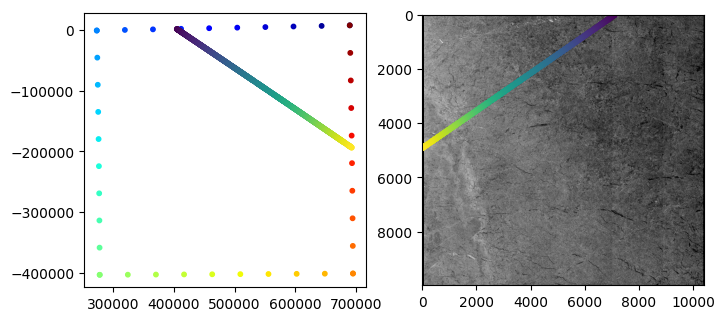

In [8]:
# find columns / rows and index of good pixels
col = s1geo.lndi_s((x, y))
row = s1geo.lndi_l((x, y))
gpi = np.nonzero(np.isfinite(col))[0]
orb_idx = np.arange(gpi.size)

# plot border and orbit to check collocation
bx, by = s1geo.get_border()
bidx = np.arange(bx.size)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(bx, by, 10, bidx, cmap='jet')
axs[0].scatter(x[gpi], y[gpi], 10, orb_idx)
axs[0].set_aspect('equal')
axs[1].imshow(sar_primary[::5, ::5], extent=[0, sar_primary.shape[1], sar_primary.shape[0], 0], cmap='gray', clim=[-20, -5])
axs[1].scatter(col[gpi], row[gpi], 10, orb_idx)
plt.show()

# The border polygon is created from points taken starting from upper left corner -> UR -> LR -> LL -> UL.
# Since the image is flipped, the order appears flipped when plotted in georeferenced coordinates.
# But the orbit line crosess the SAR image correctly: from the upper side to the left side (side with lower column number).

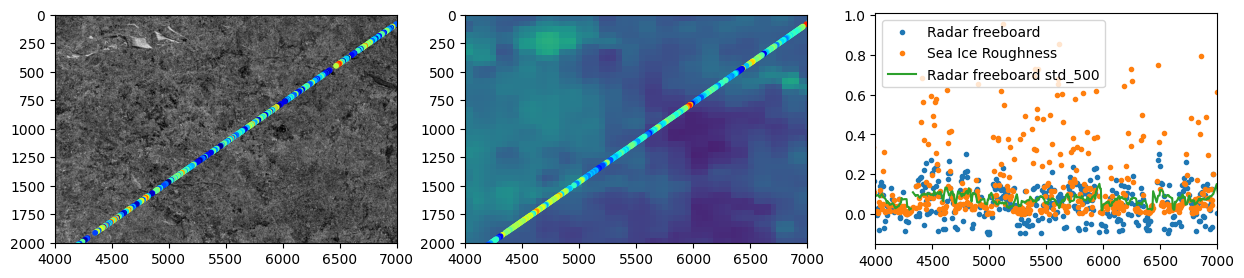

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].imshow(sar_primary, cmap='gray', clim=[-20, -5])
axs[0].scatter(col[gpi], row[gpi], 10, rf[gpi], cmap='jet')
axs[0].set_xlim([4000, 7000])
axs[0].set_ylim([2000, 0])

axs[1].imshow(btemp_89, extent=[0, sar_primary.shape[1], sar_primary.shape[0], 0])
axs[1].scatter(col[gpi], row[gpi], 10, rf_std[gpi], cmap='jet')
axs[1].set_xlim([4000, 7000])
axs[1].set_ylim([2000, 0])

axs[2].plot(col[gpi], rf[gpi], '.', label='Radar freeboard')
axs[2].plot(col[gpi], sir[gpi], '.', label='Sea Ice Roughness')
axs[2].plot(col[gpi], rf_std[gpi], '-', label='Radar freeboard std_500')
axs[2].set_xlim([4000, 7000])
plt.legend()
